# Create dataset of expressions for training similar-expressions model

## Using custom generator (based on NeSymRes and DLSM code)

Creates .txt file with string expressions.

In [83]:
from importlib import reload
import utils
import generator
reload(utils)
reload(generator)
from generator import Generator
from utils import create_generator
import os
import numpy as np
np.random.seed(2)

gen, params = create_generator('./data_settings.json')
# gen.generate_equation(np.random, -1e3, 1e3, simplify=False, check_const_range=True)

# Generate data
N = int(1e5)
expressions = [gen.generate_equation(np.random, -1, 1, simplify=False, check_const_range=True) for _ in range(N)]

In [84]:
expressions[:10]

['sin(0.7418164014816284)',
 'exp(0.5811755657196045)',
 '((0.5323680639266968*x1)/x1)- x1',
 '(exp((-0.9104486703872681)+x1))+(-0.6661405563354492)',
 '(0.7553950548171997/0.92982017993927)/x1',
 'x1+(x1/sin(x1))',
 '0.008991003036499023- x1',
 '(-0.27322161197662354)- (x1*0.02661740779876709)',
 'sin(x1)/(-0.39094078540802)',
 'exp(x1*exp(0.998916506767273))']

In [85]:
datapath = '/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/data'

# Filter out empty strings
expressions = [expr for expr in expressions if expr]

# Save
output_file = os.path.join(datapath, 'expr_240811_1.txt')
with open(output_file, 'w') as f:
    for expr in expressions:
        f.write(f"{expr}\n")

## Parse string to onehot representation

### Whole dataset

In [86]:
import pandas as pd
import h5py
from model.grammar import GCFG

In [87]:
from importlib import reload
import parsing
reload(parsing)
from parsing import parse_dataset

# Load data
datapath = r'/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/data/expr_240811_1.txt'
with open(datapath, 'r') as f:
    eqs = f.readlines()
    eqs = [eq.strip('\n') for eq in eqs]

# Parse dataset
syntax, invalid, consts = parse_dataset(eqs)

# Save parsed dataset
with h5py.File(f'{datapath[:-4]}-parsed.h5', 'w') as f:
    f.create_dataset('data', data=syntax)
    f.create_dataset('invalid_indices', data=invalid)

## Create function value dataset

In [88]:
import os
import sys
project_root = os.path.dirname(os.path.abspath(''))
sys.path.insert(0, project_root)
sys.path.insert(0, os.path.join(project_root, 'model'))
sys.path.insert(0, os.path.join(project_root, 'dataset_generation'))

In [89]:
from model.util import load_raw_parsed_data

datapath = '/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/data'
name = 'expr_240811_1'
eqs, syntax = load_raw_parsed_data(datapath, name)

In [90]:
import sympy as sp
from sympy import oo, zoo, nan

MAX_ABS_VAL = 1e5

x = np.linspace(-10, 10, 100)
y = np.empty((len(eqs), len(x)))

import multiprocess as mp

def process_equation(args):
    eq, all_x = args

    expr = sp.sympify(eq)
    if expr.has(oo, -oo, zoo, nan):
        return np.full(len(all_x), np.nan, dtype=np.float32)

    try:
        res = np.zeros(len(all_x), dtype=np.float32)
        for i, x in enumerate(all_x):
            value = expr.evalf(subs={sp.Symbol('x1'): x})
            if abs(value) < np.finfo(np.float32).max:
                res[i] = value
            else:
                return np.full(len(all_x), np.nan, dtype=np.float32)
        return res
    except TypeError:
        return np.full(len(all_x), np.nan, dtype=np.float32)


with mp.Pool() as pool:
    results = pool.map(process_equation, [(eq, x) for eq in eqs])

y = np.array(results).astype(np.float32)

invalid = np.any(np.isinf(y) | (np.abs(y) > MAX_ABS_VAL) | np.isnan(y), axis=1)
invalid.sum() / len(invalid)

values = y[~invalid]

In [91]:
import h5py

# Save parsed dataset
with h5py.File(f'{datapath}/{name}-values.h5', 'w') as f:
    f.create_dataset('data', data=values)
    f.create_dataset('invalid_mask', data=invalid)

## Analyse syntax data

In [35]:
from util import load_raw_parsed_value_data
import pandas as pd
import numpy as np

datapath = '/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/data'
eqs, syntax, values = load_raw_parsed_value_data(datapath, 'expr_240810_1')

In [36]:
prod_idx = syntax[:, :, :-1].argmax(axis=-1)

unique_rows, counts = np.unique(prod_idx, axis=0, return_counts=True)
print(f"Number of unique rows: {len(unique_rows)}")
res = sorted(zip(unique_rows, counts), key=lambda x: x[1], reverse=True)

for row, count in res[:10]:
    print(f"Row: {row}, Count: {count}")

Number of unique rows: 3033
Row: [ 4  6  4  8 10 10 10 10 10 10 10 10 10 10 10], Count: 418
Row: [ 4  7  4  8 10 10 10 10 10 10 10 10 10 10 10], Count: 402
Row: [ 4  7  4  9 10 10 10 10 10 10 10 10 10 10 10], Count: 398
Row: [ 4  6  4  9 10 10 10 10 10 10 10 10 10 10 10], Count: 396
Row: [ 0  4  8  8 10 10 10 10 10 10 10 10 10 10 10], Count: 110
Row: [ 2  4  8  8 10 10 10 10 10 10 10 10 10 10 10], Count: 106
Row: [ 3  4  8  8 10 10 10 10 10 10 10 10 10 10 10], Count: 104
Row: [ 1  4  8  8 10 10 10 10 10 10 10 10 10 10 10], Count: 103
Row: [ 4  7  4  7  4  9 10 10 10 10 10 10 10 10 10], Count: 76
Row: [ 4  6  4  6  4  8 10 10 10 10 10 10 10 10 10], Count: 74


In [52]:
from util import logits_to_prods, prods_to_eq
from grammar import GCFG
import torch


# Print 5 expressions with the same production
n = 14
for i in np.where(np.all(prod_idx == res[n][0], axis=1))[0][:5]:
    prods = logits_to_prods(torch.tensor(syntax[i].squeeze()), GCFG)
    eq = prods_to_eq(prods)
    print(eq)
    

0.5310274362564087 / x1
0.1045372486114502 / x1
0.22659552097320557 / x1
0.7463392019271851 / x1
0.03082895278930664 / x1


In [415]:
# Print expressions from each unique production

for n in range(20):
    i = np.where(np.all(prod_idx == res[n][0], axis=1))[0][0]
    prods = logits_to_prods(torch.tensor(syntax[i].squeeze()), GCFG, insert_const=False)
    eq = prods_to_eq(prods)
    print(n, '\t', eq)

0 	 sin( exp( exp( x1 ) ) )
1 	 exp( exp( sin( x1 ) ) )
2 	 sin( exp( sin( x1 ) ) )
3 	 exp( exp( sin( [CONST] ) ) )
4 	 sin( exp( sin( [CONST] ) ) )
5 	 sin( exp( exp( [CONST] ) ) )
6 	 sin( sin( exp( [CONST] ) ) )
7 	 exp( sin( sin( [CONST] ) ) )
8 	 sin( sin( exp( x1 ) ) )
9 	 exp( exp( exp( [CONST] ) ) )
10 	 sin( sin( sin( [CONST] ) ) )
11 	 exp( sin( exp( x1 ) ) )
12 	 sin( sin( sin( x1 ) ) )
13 	 exp( sin( sin( x1 ) ) )
14 	 exp( sin( exp( [CONST] ) ) )
15 	 x1 / exp( sin( x1 ) )
16 	 sin( sin( x1 ) ) + x1
17 	 x1 + exp( sin( x1 ) )
18 	 x1 * sin( sin( x1 ) )
19 	 x1 * sin( exp( x1 ) )


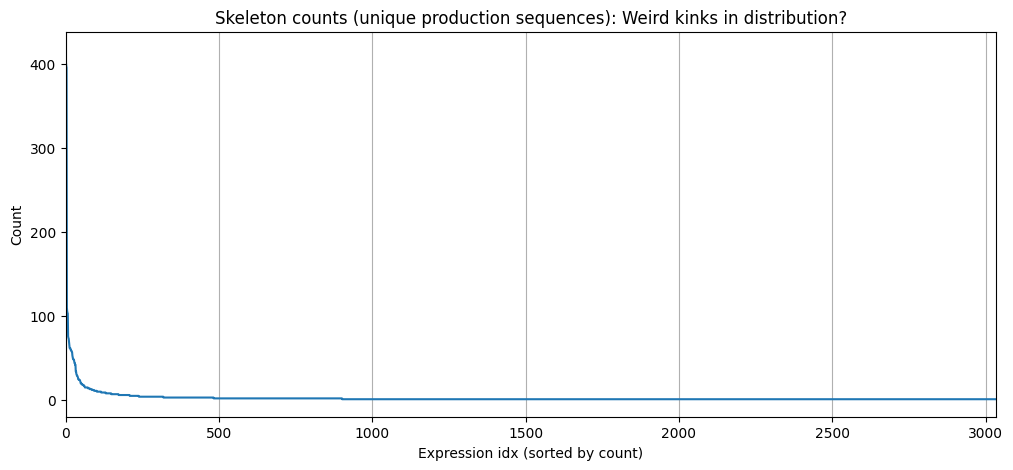

In [23]:
from matplotlib import pyplot as plt

counts_sorted = np.sort(counts)[::-1]

fig, ax = plt.subplots(figsize=(12, 5))
plt.plot(counts_sorted)
# ax2 = plt.twinx()
# ax2.plot(pd.Series(counts_sorted).diff().rolling(window=2).mean(), color='orange')
# ax2.set_ylabel('Count diff')

ax.set_xlabel('Expression idx (sorted by count)')
ax.set_ylabel('Count')
plt.xlim(0, len(counts_sorted))
# plt.xlim(1000, len(res))
# ax.set_ylim(0, 50)
ax.grid(axis='x')
plt.title('Skeleton counts (unique production sequences): Weird kinks in distribution?')
plt.show()

In [24]:
prod_counts = pd.Series(syntax[:, :, :-1].argmax(axis=-1).flatten()).value_counts()
labels = {i: str(prod) for i, prod in enumerate(GCFG.productions())}
prod_counts.index = prod_counts.index.map(labels)
prod_counts

Nothing -> None      69840
S -> T               24777
T -> '[CONST]'       10059
T -> 'x1'             9974
T -> '(' S ')'        7767
T -> 'sin(' S ')'     4181
T -> 'exp(' S ')'     3449
S -> S '-' T          2762
S -> S '+' T          2720
S -> S '/' T          2638
S -> S '*' T          2533
Name: count, dtype: int64

In [106]:
labels

{0: "S -> S '+' T",
 1: "S -> S '-' T",
 2: "S -> S '*' T",
 3: "S -> S '/' T",
 4: 'S -> T',
 5: "T -> '(' S ')'",
 6: "T -> 'sin(' S ')'",
 7: "T -> 'exp(' S ')'",
 8: "T -> 'x1'",
 9: "T -> '[CONST]'",
 10: 'Nothing -> None'}

In [109]:
# Count operators per expression

op_indices = [0, 1, 2, 3, 6, 7] #  [i for i, label in labels.items() for op_str in ['+', '-', '*', '/', 'sin', 'exp'] if op_str in label]
is_op = np.zeros(len(labels), dtype=bool)
is_op[op_indices] = 1

op_counts = np.sum(is_op * syntax[:, :, :-1], axis=(1, 2)).astype(int)
print('Operator counts:')
pd.Series(op_counts).value_counts()

Operator counts:


1    33275
2    31591
3    28652
Name: count, dtype: int64

In [108]:
# Count variables per expression
var_indices = [8]
is_var = np.zeros(len(labels), dtype=bool)
is_var[var_indices] = 1
var_counts = np.sum(is_var * syntax[:, :, :-1], axis=(1, 2)).astype(int)
print('Variable x1 counts:')
pd.Series(var_counts).value_counts()

Variable x1 counts:


1    41982
0    25767
2    20586
3     4725
4      458
Name: count, dtype: int64

## Analyse function value data

Use this to decide on value transformation

In [92]:
from util import load_raw_parsed_value_data
import pandas as pd
import numpy as np

datapath = '/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/data'
eqs, syntax, values = load_raw_parsed_value_data(datapath, 'expr_240811_1')
x = np.linspace(-10, 10, 100)

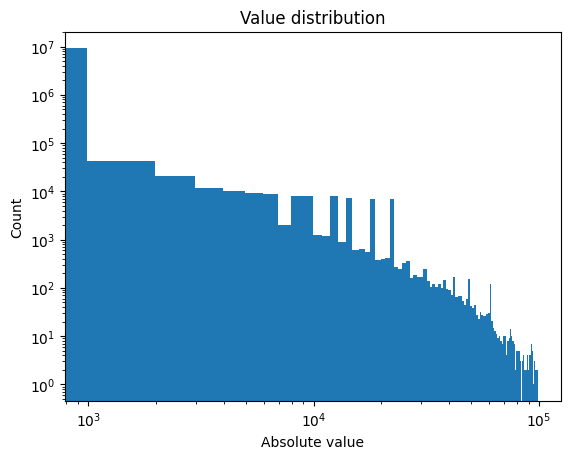

count    9.351800e+06
mean     9.602307e+01
std      1.444952e+03
min     -9.773607e+04
25%     -4.999421e-01
50%      2.863893e-01
75%      1.456452e+00
max      9.903155e+04
dtype: float64

In [118]:
from matplotlib import pyplot as plt

a = pd.Series(values.flatten())
plt.hist(a.abs(), bins=100)

plt.title('Value distribution')
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Count')
plt.xlabel('Absolute value')
plt.show()

a.describe()

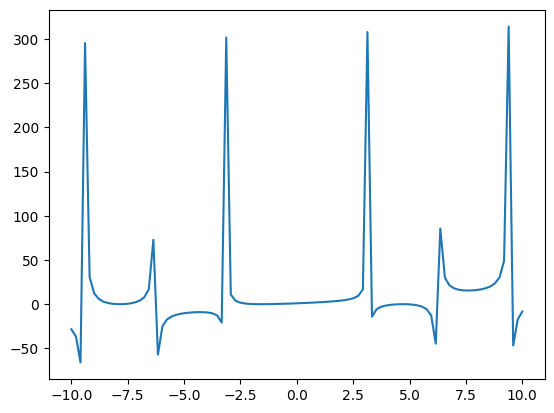

In [103]:
# Example function
plt.plot(x, values[5, :].T)

In [122]:
def value_transform(x):
    eps = 1e-10
    return torch.log(torch.abs(x) + eps)/10  # Example transformation

y_transformed = value_transform(torch.tensor(values)).detach().numpy()

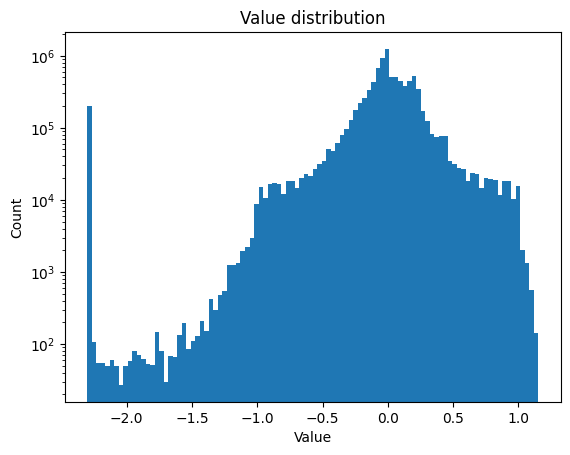

count    9.351800e+06
mean    -3.700350e-02
std      4.181543e-01
min     -2.302585e+00
25%     -9.721304e-02
50%     -3.921424e-03
75%      1.403990e-01
max      1.150319e+00
dtype: float64

In [123]:
from matplotlib import pyplot as plt

a = pd.Series(y_transformed.flatten())
plt.hist(a, bins=100)

plt.title('Value distribution')
plt.yscale('log')
plt.ylabel('Count')
plt.xlabel('Value')
plt.show()

a.describe()

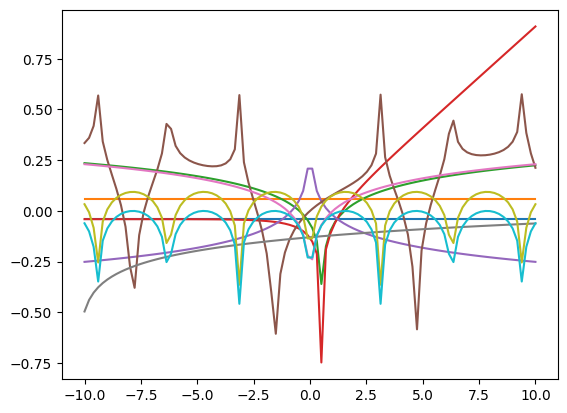

In [124]:
from matplotlib import pyplot as plt

plt.plot(x, y_transformed[:10, :].T)
plt.show()

## Analyse priors: syntax, constant function value

In [429]:
from util import load_raw_parsed_value_data
import pandas as pd
import numpy as np
from grammar import GCFG

datapath = '/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/data'
eqs, syntax, values = load_raw_parsed_value_data(datapath, 'expr_240809_1')

def value_transform(x):
    eps = 1e-10
    return torch.log(torch.abs(x) + eps)/10  # Example transformation


# Calculate production counts
prod_counts = pd.Series(syntax[:, :, :-1].argmax(axis=-1).flatten()).value_counts()
labels = {i: str(prod) for i, prod in enumerate(GCFG.productions())}
prod_counts.index = prod_counts.index.map(labels)
print(prod_counts)

# Calculate cross entropy prior for syntax
p = prod_counts / prod_counts.sum()
cross_entropy_prior = -np.sum(p * np.log(p))
print(f'\n{cross_entropy_prior = }')

# Calculate MSE prior for constants
consts = syntax[:, :, -1].flatten()
mse_prior_consts = consts.var()
print(f'{mse_prior_consts = }')

# Calculate MSE prior for values
values_transformed = value_transform(torch.tensor(values)).flatten().detach().numpy()
mse_prior_values = values_transformed.var()
print(f'{mse_prior_values = }')

Nothing -> None      34998
S -> T               31494
T -> '(' S ')'       12524
T -> 'x1'            12087
T -> '[CONST]'       11833
T -> 'sin(' S ')'     5643
T -> 'exp(' S ')'     4749
S -> S '-' T          3923
S -> S '+' T          3854
S -> S '/' T          3827
S -> S '*' T          3738
Name: count, dtype: int64

cross_entropy_prior = 2.0447648982274034
mse_prior_consts = 0.0307035554081931
mse_prior_values = 0.14959595


## Julia implementation debugging

In [10]:
import numpy as np

In [7]:
# generation parameters. FIXME?
nl = 1  # self.n_leaves
p1 = 1  # len(self.una_ops)
p2 = 1  # len(self.bin_ops)


def generate_ubi_dist(max_ops):
    """
    `max_ops`: maximum number of operators
    Enumerate the number of possible unary-binary trees that can be generated from empty nodes.
    D[e][n] represents the number of different binary trees with n nodes that
    can be generated from e empty nodes, using the following recursion:
        D(0, n) = 0
        D(e, 0) = L ** e
        D(e, n) = L * D(e - 1, n) + p_1 * D(e, n - 1) + p_2 * D(e + 1, n - 1)
    """
    # enumerate possible trees
    # first generate the tranposed version of D, then transpose it
    D = []
    D.append([0] + ([nl ** i for i in range(1, 2 * max_ops + 1)]))
    for n in range(1, 2 * max_ops + 1):  # number of operators
        s = [0]
        for e in range(1, 2 * max_ops - n + 1):  # number of empty nodes
            s.append(
                nl * s[e - 1]
                + p1 * D[n - 1][e]
                + p2 * D[n - 1][e + 1]
            )
        D.append(s)
    assert all(len(D[i]) >= len(D[i + 1]) for i in range(len(D) - 1))
    D = [
        [D[j][i] for j in range(len(D)) if i < len(D[j])]
        for i in range(max(len(x) for x in D))
    ]
    return D

ubi_dist = generate_ubi_dist(4)
ubi_dist

[[0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 2, 6, 22, 90, 394, 1806, 8558],
 [1, 4, 16, 68, 304, 1412, 6752],
 [1, 6, 30, 146, 714, 3534],
 [1, 8, 48, 264, 1408],
 [1, 10, 70, 430],
 [1, 12, 96],
 [1, 14],
 [1]]

In [31]:
def sample_next_pos_ubi(nb_empty, nb_ops, rng):
    """
    Sample the position of the next node (unary-binary case).
    Sample a position in {0, ..., `nb_empty` - 1}, along with an arity.
    """
    assert nb_empty > 0
    assert nb_ops > 0
    probs = []
    for i in range(nb_empty):
        probs.append(
            (nl ** i) * p1 * ubi_dist[nb_empty - i][nb_ops - 1]
        )
    for i in range(nb_empty):
        probs.append(
            (nl ** i) * p2 * ubi_dist[nb_empty - i + 1][nb_ops - 1]
        )
    probs = [p / ubi_dist[nb_empty][nb_ops] for p in probs]
    probs = np.array(probs, dtype=np.float64)
    e = rng.choice(2 * nb_empty, p=probs)
    arity = 1 if e < nb_empty else 2
    e = e % nb_empty
    return e, arity

sample_next_pos_ubi(1, 4, np.random)

(0, 2)